In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/kenpom-2020/NCAA2021_Kenpom.csv
/kaggle/input/kenpom-2020/Mkenpom2021.csv
/kaggle/input/ncaam-march-mania-2021/MDataFiles_Stage2/Conferences.csv
/kaggle/input/ncaam-march-mania-2021/MDataFiles_Stage2/MNCAATourneySeedRoundSlots.csv
/kaggle/input/ncaam-march-mania-2021/MDataFiles_Stage2/MRegularSeasonDetailedResults.csv
/kaggle/input/ncaam-march-mania-2021/MDataFiles_Stage2/MNCAATourneyCompactResults.csv
/kaggle/input/ncaam-march-mania-2021/MDataFiles_Stage2/MGameCities.csv
/kaggle/input/ncaam-march-mania-2021/MDataFiles_Stage2/MSampleSubmissionStage2.csv
/kaggle/input/ncaam-march-mania-2021/MDataFiles_Stage2/MSeasons.csv
/kaggle/input/ncaam-march-mania-2021/MDataFiles_Stage2/MSecondaryTourneyTeams.csv
/kaggle/input/ncaam-march-mania-2021/MDataFiles_Stage2/Cities.csv
/kaggle/input/ncaam-march-mania-2021/MDataFiles_Stage2/MTeamSpellings.csv
/kaggle/input/ncaam-march-mania-2021/MDataFiles_Stage2/MRegularSeasonCompactResults.csv
/kaggle/input/ncaam-march-mania-2021/MDataFiles_

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

seeds = pd.read_csv('../input/ncaam-march-mania-2021/MDataFiles_Stage2/MNCAATourneySeeds.csv')
tourney_results = pd.read_csv('../input/ncaam-march-mania-2021/MDataFiles_Stage2/MNCAATourneyCompactResults.csv')
regular_results = pd.read_csv('../input/ncaam-march-mania-2021/MDataFiles_Stage2/MRegularSeasonCompactResults.csv')
test_df = pd.read_csv('../input/ncaam-march-mania-2021/MDataFiles_Stage2/MSampleSubmissionStage2.csv')

In [3]:
def prepare_data(df):
    dfswap = df[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT']]

    dfswap.loc[df['WLoc'] == 'H', 'WLoc'] = 'A'
    dfswap.loc[df['WLoc'] == 'A', 'WLoc'] = 'H'
    df.columns.values[6] = 'location'
    dfswap.columns.values[6] = 'location'         
    df.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(df.columns)]
    dfswap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(dfswap.columns)]
    output = pd.concat([df, dfswap]).sort_index().reset_index(drop=True)
    
    return output

In [4]:
tourney_results = prepare_data(tourney_results)
regular_results = prepare_data(regular_results)

In [5]:
# convert to str, so the model would treat TeamID them as factors
regular_results['T1_TeamID'] = regular_results['T1_TeamID'].astype(str)
regular_results['T2_TeamID'] = regular_results['T2_TeamID'].astype(str)

# make it a binary task
regular_results['win'] = np.where(regular_results['T1_Score']>regular_results['T2_Score'], 1, 0)

def team_quality(season):
    """
    Calculate team quality for each season seperately. 
    Team strength changes from season to season (students playing change!)
    So pooling everything would be bad approach!
    """
    formula = 'win~-1+T1_TeamID+T2_TeamID'
    glm = sm.GLM.from_formula(formula=formula, 
                              data=regular_results.loc[regular_results.Season==season,:], 
                              family=sm.families.Binomial()).fit()
    
    # extracting parameters from glm
    quality = pd.DataFrame(glm.params).reset_index()
    quality.columns = ['TeamID','beta']
    quality['Season'] = season
    # taking exp due to binomial model being used
    quality['quality'] = np.exp(quality['beta'])
    # only interested in glm parameters with T1_, as T2_ should be mirroring T1_ ones
    quality = quality.loc[quality.TeamID.str.contains('T1_')].reset_index(drop=True)
    quality['TeamID'] = quality['TeamID'].apply(lambda x: x[10:14]).astype(int)
    return quality

In [6]:
team_quality = pd.concat([team_quality(2010),
                          team_quality(2011),
                          team_quality(2012),
                          team_quality(2013),
                          team_quality(2014),
                          team_quality(2015),
                          team_quality(2016),
                          team_quality(2017),
                          team_quality(2018),
                         team_quality(2019),
                         team_quality(2020),
                          team_quality(2021)]).reset_index(drop=True)

In [7]:
team_quality.head()

,TeamID,beta,Season,quality
0,1102,3.244962e-14,2010,1.000000
1,1103,1.860166e+00,2010,6.424804
2,1104,2.522218e+00,2010,12.456189
3,1105,-2.751948e+00,2010,0.063803
4,1106,-1.738015e+00,2010,0.175869


In [8]:
team_quality_T1 = team_quality[['TeamID','Season','quality']]
team_quality_T1.columns = ['T1_TeamID','Season','T1_quality']
team_quality_T2 = team_quality[['TeamID','Season','quality']]
team_quality_T2.columns = ['T2_TeamID','Season','T2_quality']

tourney_results['T1_TeamID'] = tourney_results['T1_TeamID'].astype(int)
tourney_results['T2_TeamID'] = tourney_results['T2_TeamID'].astype(int)
tourney_results = tourney_results.merge(team_quality_T1, on = ['T1_TeamID','Season'], how = 'left')
tourney_results = tourney_results.merge(team_quality_T2, on = ['T2_TeamID','Season'], how = 'left')

In [9]:
# we only have tourney results since year 2010
tourney_results = tourney_results.loc[tourney_results['Season'] >= 2010].reset_index(drop=True)

# not interested in pre-selection matches
tourney_results = tourney_results.loc[tourney_results['DayNum'] >= 136].reset_index(drop=True)

In [10]:
seeds['seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))
seeds['division'] = seeds['Seed'].apply(lambda x: x[0])

seeds_T1 = seeds[['Season','TeamID','seed','division']].copy()
seeds_T2 = seeds[['Season','TeamID','seed','division']].copy()
seeds_T1.columns = ['Season','T1_TeamID','T1_seed','T1_division']
seeds_T2.columns = ['Season','T2_TeamID','T2_seed','T2_division']

tourney_results = tourney_results.merge(seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_results = tourney_results.merge(seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [11]:
tourney_results['T1_powerrank'] = tourney_results.groupby(['Season','T1_division'])['T1_quality'].rank(method='dense', ascending=False).astype(int)
tourney_results['T2_powerrank'] = tourney_results.groupby(['Season','T2_division'])['T2_quality'].rank(method='dense', ascending=False).astype(int)

In [12]:
piv = pd.pivot_table(tourney_results, index = ['T1_seed'], columns=['T1_powerrank'], values = ['T1_TeamID'], aggfunc=len)
piv = piv.xs('T1_TeamID', axis=1, drop_level=True)

<AxesSubplot:xlabel='T1_powerrank', ylabel='T1_seed'>

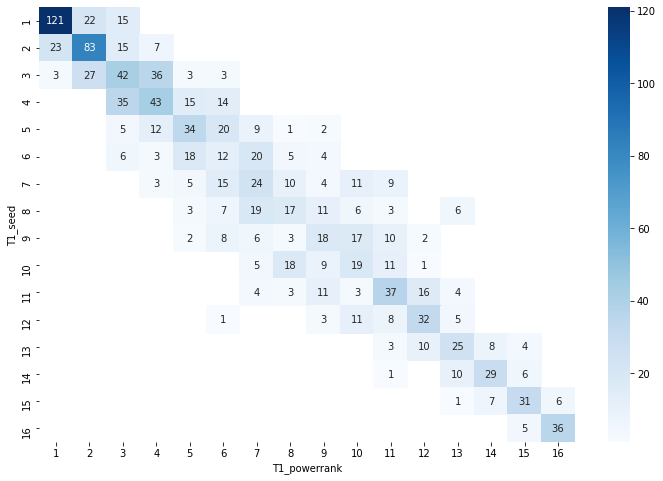

In [13]:
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(piv, annot=True,cmap='Blues', fmt='g')

In [14]:
tourney_results['win'] = np.where(tourney_results['T1_Score'] > tourney_results['T2_Score'], 1, 0)

In [15]:
mean_win_ratio = pd.DataFrame({'seed_win_ratio': tourney_results.groupby('T1_seed')['win'].mean(),
                               'powerrank_win_ratio': tourney_results.groupby('T1_powerrank')['win'].mean()})
mean_win_ratio

,seed_win_ratio,powerrank_win_ratio
1,0.791139,0.768707
2,0.695312,0.704545
3,0.657895,0.677966
4,0.626168,0.615385
5,0.518072,0.500000
6,0.411765,0.512500
7,0.518519,0.540230
8,0.444444,0.298246
9,0.393939,0.354839
10,0.365079,0.402985


In [16]:
test_df.head()

,ID,Pred
0,2021_1101_1104,0.5
1,2021_1101_1111,0.5
2,2021_1101_1116,0.5
3,2021_1101_1124,0.5
4,2021_1101_1140,0.5


In [17]:
test_df['Season'] = test_df['ID'].apply(lambda x: int(x.split('_')[0]))
test_df['T1_TeamID'] = test_df['ID'].apply(lambda x: int(x.split('_')[1]))
test_df['T2_TeamID'] = test_df['ID'].apply(lambda x: int(x.split('_')[2]))

In [18]:
test_df = pd.merge(test_df, team_quality_T1, left_on=['Season', 'T1_TeamID'], right_on=['Season', 'T1_TeamID'], how='left')
test_df = pd.merge(test_df, team_quality_T2, left_on=['Season', 'T2_TeamID'], right_on=['Season', 'T2_TeamID'], how='left')

In [19]:
test_df = pd.merge(test_df,seeds_T1, left_on=['Season', 'T1_TeamID'], right_on=['Season', 'T1_TeamID'], how='left')
test_df.rename(columns={'Seed':'Seed1'}, inplace=True)
test_df = test_df.drop('T1_division', axis=1)

test_df = pd.merge(test_df,seeds_T2, left_on=['Season', 'T2_TeamID'], right_on=['Season', 'T2_TeamID'], how='left')
test_df.rename(columns={'Seed':'Seed2'}, inplace=True)
test_df = test_df.drop('T2_division', axis=1)

In [20]:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression

In [21]:
def get_train_test(df, test_season):
    train_df = df.loc[df['Season']<test_season, cols+['win']]
    test_df = df.loc[df['Season']==test_season, cols+['win']]
    return train_df, test_df

In [22]:
tourney_results.tail()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_quality,T2_quality,T1_seed,T1_division,T2_seed,T2_division,T1_powerrank,T2_powerrank,win
1255,2019,152,1403,61,1277,51,N,0,39.415018,60.085118,3,X,2,W,4,2,1
1256,2019,152,1120,62,1438,63,N,0,28.628348,153.259286,5,Y,1,Z,5,1,0
1257,2019,152,1438,63,1120,62,N,0,153.259286,28.628348,1,Z,5,Y,1,5,1
1258,2019,154,1438,85,1403,77,N,1,153.259286,39.415018,1,Z,3,X,1,4,1
1259,2019,154,1403,77,1438,85,N,1,39.415018,153.259286,3,X,1,Z,4,1,0


In [23]:
cols = ['T1_quality','T2_quality','T1_seed','T2_seed']

In [24]:
model1 = LogisticRegression()

In [25]:
#model 1
gloss = 0
seasons = [2015, 2016, 2017, 2018, 2019]

for season in seasons:
    train, test = get_train_test(tourney_results, season)
    model1.fit(train.drop('win', axis=1), train['win'])
    pred = model1.predict_proba(test.drop('win', axis=1))[:,1]
    loss = log_loss(test['win'], pred)
    print(season, loss)
    gloss += loss

print('average', gloss/len(seasons))

2015 0.6931471799984354
2016 0.693147180544288
2017 0.6931471805471684
2018 0.6931471805553129
2019 0.6931471805576734
average 0.6931471804405757


In [26]:
#model2=LGBMClassifier(num_leaves=200,min_child_weight=0.1,bagging_fraction=0.418,random_state= 47,reg_lambda=0.91,metric='logloss',learning_rate=0.141,min_data_in_leaf=96,bagging_seed=12,max_depth= -1,)
model2=LGBMClassifier(num_leaves=70,min_child_weight=0.1,bagging_fraction=0.418,random_state= 47,reg_lambda=0.91,metric='logloss',learning_rate=0.15,min_data_in_leaf=120,bagging_seed=12,max_depth= -1,verbosity= -1,)

In [27]:
#learning_rate=0.141 :0.5636729157798956
0.558
2019 0.5123786901528392
average 0.5573684763745903

SyntaxError: invalid syntax (<ipython-input-27-34be69293290>, line 3)

In [28]:
#model 2
gloss = 0
seasons = [2015, 2016, 2017, 2018, 2019]

for season in seasons:
    train, test = get_train_test(tourney_results, season)
    model2.fit(train.drop('win', axis=1), train['win'])
    pred = model2.predict_proba(test.drop('win', axis=1))[:,1]
    loss = log_loss(test['win'], pred)
    print(season, loss)
    gloss += loss

print('average', gloss/len(seasons))

[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.418, subsample=1.0 will be ignored. Current value: bagging_fraction=0.418
2015 0.5340623599727916
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.418, subsample=1.0 will be ignored. Current value: bagging_fraction=0.418
2016 0.5761221933630143
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.418, subsample=1.0 will be ignored. Current value: bagging_fraction=0.418
2017 0.5325939748023709
[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.418, subsample=1.0 wil

In [29]:
model3=XGBClassifier(gamma=0.25,
                   n_estimators=5000,max_depth=3,colsample_bytree=0.8,                 
                   learning_rate=0.05,
      nthread = 12)

In [30]:
#model 3
gloss = 0
seasons = [2015, 2016, 2017, 2018, 2019]

for season in seasons:
    train, test = get_train_test(tourney_results, season)
    model3.fit(train.drop('win', axis=1), train['win'])
    pred = model3.predict_proba(test.drop('win', axis=1))[:,1]
    loss = log_loss(test['win'], pred)
    print(season, loss)
    gloss += loss

print('average', gloss/len(seasons))

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:21:30] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
2015 0.7120878255024315
[14:21:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


2016 0.6440938159006663
[14:22:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


2017 0.5646693141842705
[14:22:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


2018 0.7074761498384067
[14:22:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


2019 0.5784970778317767
average 0.6413648366515103


In [31]:
model4=CatBoostClassifier(iterations=500,depth=10,colsample_bylevel=0.5,early_stopping_rounds=400,l2_leaf_reg=25,random_seed=42)

In [32]:
#2019 0.49509748674053056
#average 0.5520591637759703

#2019 0.4952941636487547
#average 0.5471855762910673

#2019 0.4952576486724039
#average 0.5438677919838486

#2019 0.499242597893472
#average 0.5382684996821872
2019 0.4937852749605801
average 0.5385315297869372
2019 0.47251270704061776
average 0.5466135130417922

SyntaxError: invalid syntax (<ipython-input-32-da0f8dd29eb4>, line 12)

In [33]:
#model 4
gloss = 0
seasons = [2015, 2016, 2017, 2018, 2019]

for season in seasons:
    train, test = get_train_test(tourney_results, season)
    model4.fit(train.drop('win', axis=1), train['win'])
    pred = model4.predict_proba(test.drop('win', axis=1))[:,1]
    loss = log_loss(test['win'], pred)
    print(season, loss)
    gloss += loss

print('average', gloss/len(seasons))

0:	learn: 0.6903487	total: 54.5ms	remaining: 27.2s
1:	learn: 0.6847228	total: 70ms	remaining: 17.4s
2:	learn: 0.6793332	total: 81.8ms	remaining: 13.6s
3:	learn: 0.6744389	total: 84.9ms	remaining: 10.5s
4:	learn: 0.6696024	total: 86.6ms	remaining: 8.57s
5:	learn: 0.6657725	total: 94ms	remaining: 7.74s
6:	learn: 0.6616678	total: 101ms	remaining: 7.08s
7:	learn: 0.6579940	total: 101ms	remaining: 6.24s
8:	learn: 0.6537998	total: 105ms	remaining: 5.73s
9:	learn: 0.6499892	total: 111ms	remaining: 5.45s
10:	learn: 0.6465069	total: 118ms	remaining: 5.23s
11:	learn: 0.6429632	total: 121ms	remaining: 4.94s
12:	learn: 0.6398341	total: 127ms	remaining: 4.75s
13:	learn: 0.6370293	total: 130ms	remaining: 4.52s
14:	learn: 0.6345371	total: 131ms	remaining: 4.25s
15:	learn: 0.6326763	total: 133ms	remaining: 4.01s
16:	learn: 0.6298588	total: 137ms	remaining: 3.9s
17:	learn: 0.6288023	total: 138ms	remaining: 3.69s
18:	learn: 0.6265395	total: 139ms	remaining: 3.51s
19:	learn: 0.6240387	total: 145ms	remain

In [34]:
modele1=LGBMClassifier(num_leaves=70,min_child_weight=0.1,bagging_fraction=0.418,random_state= 47,reg_lambda=0.91,metric='logloss',learning_rate=0.15,min_data_in_leaf=120,bagging_seed=12,max_depth= -1,verbosity= -1,)

In [35]:
modele2=CatBoostClassifier(iterations=500,depth=10,colsample_bylevel=0.5,early_stopping_rounds=400,l2_leaf_reg=25,random_seed=42)

In [36]:
weights = {
    'modele1': 0, 
    
    'modele2': 20
}

In [37]:
#ensembling model 
gloss = 0
for season in seasons:
    train, test = get_train_test(tourney_results, season)
    modele1.fit(train.drop('win', axis=1), train['win'])
    modele2.fit(train.drop('win', axis=1), train['win'])
    pred = ((modele1.predict_proba(test.drop('win', axis=1))[:,1]*weights['modele1']+modele2.predict_proba(test.drop('win', axis=1))[:,1]*weights['modele2'])/(weights['modele1']+weights['modele2']))
    loss = log_loss(test['win'], pred)
    #f1_score=accuracy_score(test['target'], pred)
    print(season, loss)
    gloss += loss

print('average', gloss/len(seasons))

[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.418, subsample=1.0 will be ignored. Current value: bagging_fraction=0.418
0:	learn: 0.6903487	total: 705us	remaining: 352ms
1:	learn: 0.6847228	total: 6.58ms	remaining: 1.64s
2:	learn: 0.6793332	total: 12ms	remaining: 1.99s
3:	learn: 0.6744389	total: 13.8ms	remaining: 1.71s
4:	learn: 0.6696024	total: 14.7ms	remaining: 1.46s
5:	learn: 0.6657725	total: 24.5ms	remaining: 2.01s
6:	learn: 0.6616678	total: 31.2ms	remaining: 2.2s
7:	learn: 0.6579940	total: 32.1ms	remaining: 1.97s
8:	learn: 0.6537998	total: 36ms	remaining: 1.96s
9:	learn: 0.6499892	total: 42ms	remaining: 2.06s
10:	learn: 0.6465069	total: 48.2ms	remaining: 2.14s
11:	learn: 0.6429632	total: 52.4ms	remaining: 2.13s
12:	learn: 0.6398341	total: 58.7ms	remaining: 2.2s
13:	learn: 0.6370293	total: 62.5ms	remaining: 2.17s
14:	learn: 0.6345371	total: 63.8ms	remaining: 

In [38]:
submission_df = pd.read_csv('../input/ncaam-march-mania-2021/MDataFiles_Stage2/MSampleSubmissionStage2.csv')
modele1.fit(tourney_results[cols], tourney_results['win'])
modele2.fit(tourney_results[cols], tourney_results['win'])
pred = ((modele1.predict_proba(test_df[cols])[:,1]*weights['modele1']+modele2.predict_proba(test_df[cols])[:,1]*weights['modele2'])/(weights['modele1']+weights['modele2']))
test_df['Pred'] = pred.clip(0, 1)
test_df.to_csv('submission.csv', columns=['ID','Pred'], index=None)
test_df

[LightGBM] [Warning] min_data_in_leaf is set=120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=120
[LightGBM] [Warning] bagging_fraction is set=0.418, subsample=1.0 will be ignored. Current value: bagging_fraction=0.418
0:	learn: 0.6897863	total: 753us	remaining: 376ms
1:	learn: 0.6897863	total: 1.31ms	remaining: 327ms
2:	learn: 0.6853925	total: 2.04ms	remaining: 339ms
3:	learn: 0.6842717	total: 2.69ms	remaining: 333ms
4:	learn: 0.6811718	total: 3.21ms	remaining: 318ms
5:	learn: 0.6750732	total: 6.66ms	remaining: 549ms
6:	learn: 0.6685020	total: 8.92ms	remaining: 628ms
7:	learn: 0.6685019	total: 9.41ms	remaining: 579ms
8:	learn: 0.6620587	total: 11.8ms	remaining: 642ms
9:	learn: 0.6610650	total: 12.4ms	remaining: 609ms
10:	learn: 0.6552793	total: 18.7ms	remaining: 830ms
11:	learn: 0.6501516	total: 20.7ms	remaining: 842ms
12:	learn: 0.6445435	total: 24.9ms	remaining: 935ms
13:	learn: 0.6401143	total: 26.7ms	remaining: 929ms
14:	learn: 0.6355550	total: 31.9ms	rem

,ID,Pred,Season,T1_TeamID,T2_TeamID,T1_quality,T2_quality,T1_seed,T2_seed
0,2021_1101_1104,0.107963,2021,1101,1104,1.000000,26.649216,14,2
1,2021_1101_1111,0.484675,2021,1101,1111,1.000000,0.567182,14,16
2,2021_1101_1116,0.108581,2021,1101,1116,1.000000,22.230902,14,3
3,2021_1101_1124,0.029003,2021,1101,1124,1.000000,173.625149,14,1
4,2021_1101_1140,0.225927,2021,1101,1140,1.000000,18.272577,14,6
...,...,...,...,...,...,...,...,...,...
2273,2021_1452_1457,0.771584,2021,1452,1457,29.018289,3.943682,3,12
2274,2021_1452_1458,0.697701,2021,1452,1458,29.018289,18.620256,3,9
2275,2021_1455_1457,0.616255,2021,1455,1457,13.673043,3.943682,11,12
2276,2021_1455_1458,0.528212,2021,1455,1458,13.673043,18.620256,11,9
